## Notebook for recording after a certain time during training

This notebook describes the original experiment with node ranges when recording after some threshold during training

Library imports

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
use_cuda=True
from torchvision import datasets, transforms
from torch import nn, optim
import time
from tqdm import tqdm
from scipy.stats import pointbiserialr

In [6]:
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce RTX 3090']


### Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)



In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


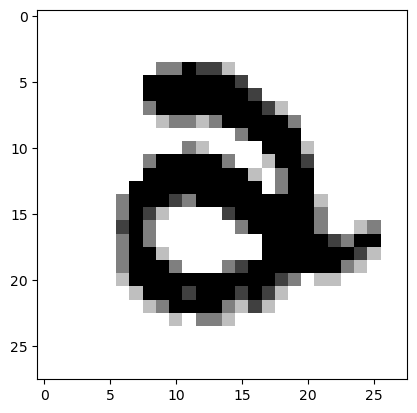

In [4]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');


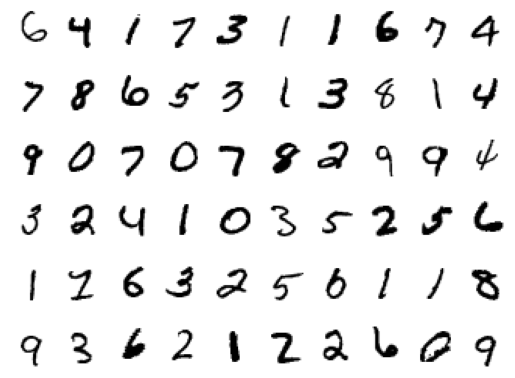

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    

Useful functions

In [7]:
def train_model(model, trainloader, criterion, optimizer, epochs=15, device='cuda', percentage_before_recording = 0.05):
    time0 = time.time()
    counter = 0

    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            

            # Training pass
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            # This is where the model learns by backpropagating
            loss.backward()

            # And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
            counter +=images.shape[0]
            if counter >= percentage_before_recording * len(trainset): # 5 percent of trainset
                    model.record = True
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

    print("\nTraining Time (in minutes) =", (time.time()-time0)/60)

In [8]:
def extract_node_value_ranges(model, num_nodes_per_layer, trim, n_std):
    if trim == True:
        model.trim_node_values(n_std)
        node_dict = model.node_dict_trimmed
    else:
        node_dict = model.node_dict
    interval_dict = create_network_dict(num_nodes_per_layer=num_nodes_per_layer)
    for layer, subdict in node_dict.items():
        for node, values in subdict.items():
            min_values = min(values)
            max_values = max(values)
            interval_dict[layer][node] = [min_values, max_values]
    return interval_dict

In [9]:
def evaluate_model(model, valloader, trim = False, n_std = 2):
    device='cuda'
    hidden_sizes = model.hidden_sizes
    value_ranges = extract_node_value_ranges(model, num_nodes_per_layer=hidden_sizes, trim = trim, n_std = n_std)
    model.eval()
    model.testing = True
    model.reset_testing_dict()
    node_count = np.sum([len(subdict) for subdict in model.node_dict_testing.values()])

    correct_count, all_count = 0, 0
    percent_list = []
    prediction_list = []

    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)

        for index_to_test in range(images.shape[0]):
            img = images[index_to_test].view(1, -1)

            with torch.no_grad():
                logps = model(img)

                true_count = 0
                for layer, subdict in model.node_dict_testing.items():
                    for node, values in subdict.items():
                        min_value, max_value = value_ranges[layer][node]
                        if min_value <= values[all_count] <= max_value:
                            true_count += 1

                all_count += 1
                percent_true = true_count / node_count * 100
                percent_list.append(percent_true)
                true_count = 0

                ps = torch.exp(logps)
                probab = list(ps.detach().cpu().numpy()[0])
                pred_label = probab.index(max(probab))
                true_label = labels[index_to_test].detach().cpu().numpy()

                if true_label == pred_label:
                    prediction_list.append(True)
                    correct_count += 1
                else:
                    prediction_list.append(False)

    accuracy = correct_count / all_count if all_count > 0 else 0.0
    return accuracy, percent_list, prediction_list



In [11]:
def plot_percentage_scatter(percentages, correct_predictions, num_points=None, ymin=0, ymax=102, title = None):
    
    
    data_points = [{'percentage_true': percent, 'correct_prediction': correct} for percent, correct in zip(percentages[:num_points], correct_predictions[:num_points])]

    percentages = [point['percentage_true'] for point in data_points]
    correct_predictions = [point['correct_prediction'] for point in data_points]

    # Plot points
    plt.figure(figsize=(12, 6))

    #progress_bar = tqdm(total=len(percentages), desc='Plotting')

    for i, (percent, correct) in enumerate(zip(percentages, correct_predictions)):
        marker = 'o' if correct else '^'
        color = 'green' if correct else 'red'
        plt.scatter(i + 1, percent, marker=marker, color=color, s=10, alpha=0.7)

        # Update the progress bar
        #progress_bar.update(1)
        #time.sleep(0.01)

    #progress_bar.close()

    plt.xlabel('Predictions')
    plt.ylabel('Percentage of True Nodes')
    if title == None:
        title = 'Scatter Plot of Percentage of True Nodes for Different Scenarios'
    plt.title(title)
    plt.ylim(ymin, ymax)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10),
                      plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10)]
    legend_labels = ['Correct Prediction', 'Incorrect Prediction']

    # Show the legend with custom handles and labels
    plt.legend(handles=legend_handles, labels=legend_labels)

    # Show the plot
    plt.show()

# Sigmoid Model

In [22]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

def create_network_dict(num_nodes_per_layer):
    network_dict = {}
    for layer in range(1, len(num_nodes_per_layer) + 1):
        layer_name = f"Layer{layer}"
        network_dict[layer_name] = {f"node{i}": [] for i in range(num_nodes_per_layer[layer - 1])}
    return network_dict

class MyModel_sigmoid(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyModel_sigmoid, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_sizes[0])
        self.sigmoid1 = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.sigmoid2 = nn.Sigmoid()
        self.layer3 = nn.Linear(hidden_sizes[1], output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.node_dict = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.node_dict_testing = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.testing = False
        self.hidden_sizes = hidden_sizes
        self.record = False
        self.node_dict_trimmed = create_network_dict(num_nodes_per_layer=hidden_sizes)

    def record_node_values(self, x, layer, hidden_sizes):
        if self.testing:
            for j in range(len(x[0])):
                self.node_dict_testing[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())
        else:
            if self.record:
                for j in range(len(x[0])):
                    self.node_dict[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())

    def forward(self, x):
        layer = 1
        x = self.sigmoid1(self.layer1(x))
        self.record_node_values(x, layer, hidden_sizes)
        layer+=1
        x = self.sigmoid2(self.layer2(x))
        self.record_node_values(x, layer, hidden_sizes)
        x = self.log_softmax(self.layer3(x))
        return x

    def reset_testing_dict(self):
        self.node_dict_testing = create_network_dict(num_nodes_per_layer=hidden_sizes)
        
    def trim_node_values(self, n_std = 2):
        for layer, subdict in self.node_dict.items():
            for node, values in subdict.items():
                values_array = np.array(values)
                mean = np.mean(values_array)
                std = np.std(values_array)
                filtered_values_array = values_array[(mean - n_std * std <= values_array) & (values_array <= mean + n_std * std)].tolist()
                self.node_dict_trimmed[layer][node] = filtered_values_array
                       
    
models_dict = {}
percent_list = [0.1, 0.2, 0.3, 0.4,0.5,0.6]
for p in percent_list:
    model = MyModel_sigmoid(input_size, hidden_sizes, output_size)
    device = torch.device('cuda')  # use cuda or cpu
    model.to(device)
    models_dict[p] = model

# Train models
for p, model in models_dict.items():
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    criterion = nn.NLLLoss()
    print(f"Training model for percentage {p}:")
    train_model(model, trainloader, criterion, optimizer, epochs=15, percentage_before_recording=p)

Training model for percentage 0.1:
Epoch 0 - Training loss: 2.2561427253141586
Epoch 1 - Training loss: 1.5894344586934617
Epoch 2 - Training loss: 0.8876640233658016
Epoch 3 - Training loss: 0.626295499583043
Epoch 4 - Training loss: 0.4935721266053633
Epoch 5 - Training loss: 0.4262821431130743
Epoch 6 - Training loss: 0.38609424702076517
Epoch 7 - Training loss: 0.3570113747295286
Epoch 8 - Training loss: 0.33393587057651486
Epoch 9 - Training loss: 0.3139203352841741
Epoch 10 - Training loss: 0.2960402913995262
Epoch 11 - Training loss: 0.27997484117714583
Epoch 12 - Training loss: 0.2650848035650975
Epoch 13 - Training loss: 0.2511803782554959
Epoch 14 - Training loss: 0.23864966610680893

Training Time (in minutes) = 3.824916144212087
Training model for percentage 0.2:
Epoch 0 - Training loss: 2.2523793515874377
Epoch 1 - Training loss: 1.5810660674755
Epoch 2 - Training loss: 0.850706816291504
Epoch 3 - Training loss: 0.598212479591878
Epoch 4 - Training loss: 0.4797697325886439

Model Accuracy = 93.45%


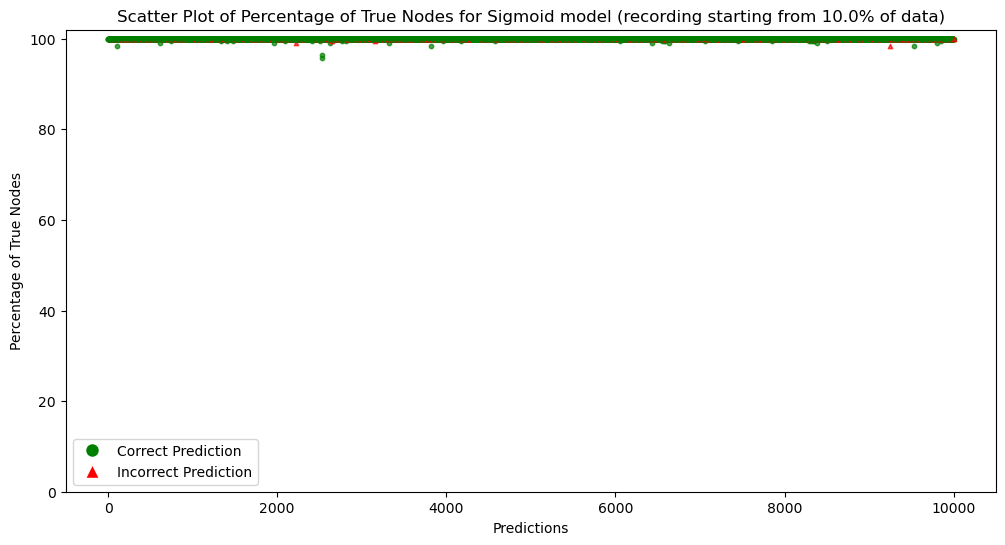

Model Accuracy = 93.74%


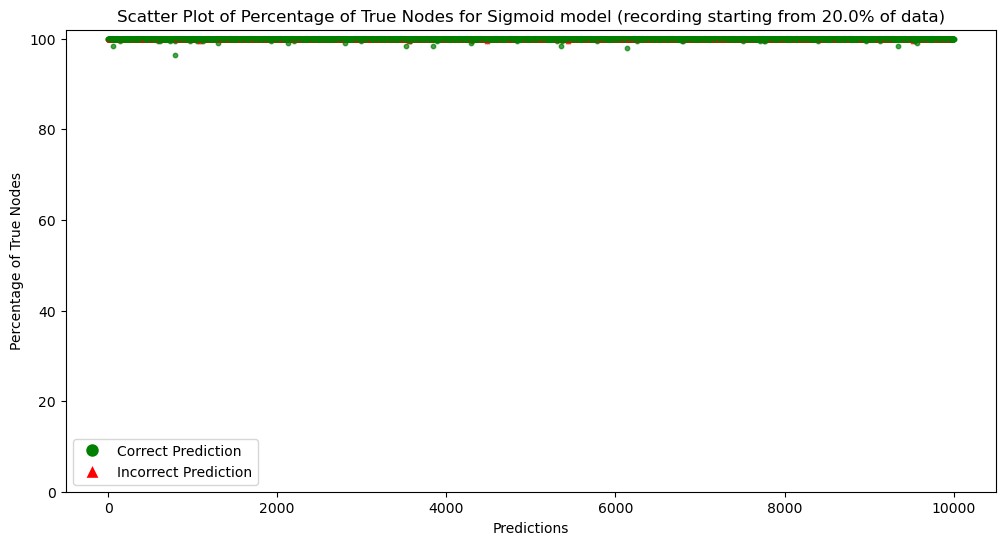

Model Accuracy = 93.25%


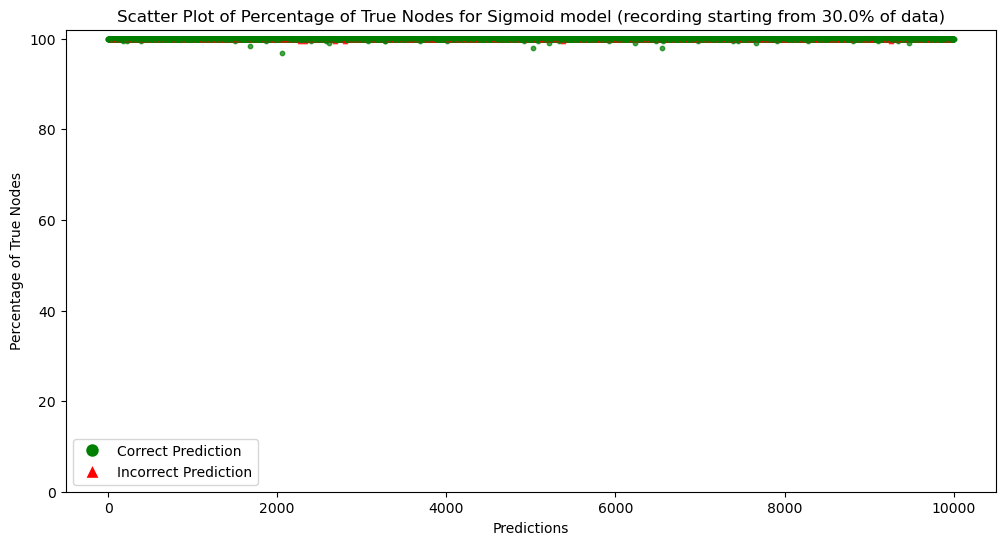

Model Accuracy = 93.19%


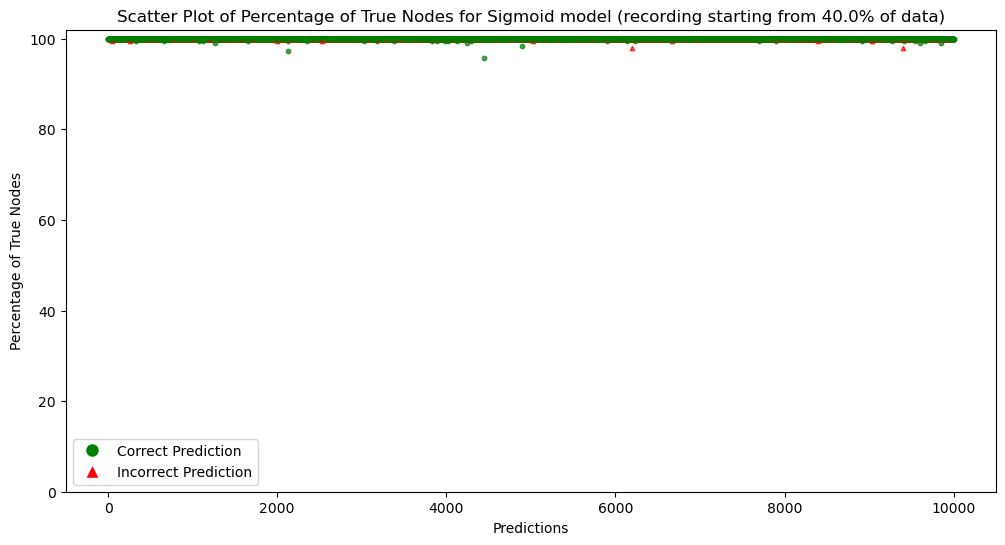

Model Accuracy = 93.44%


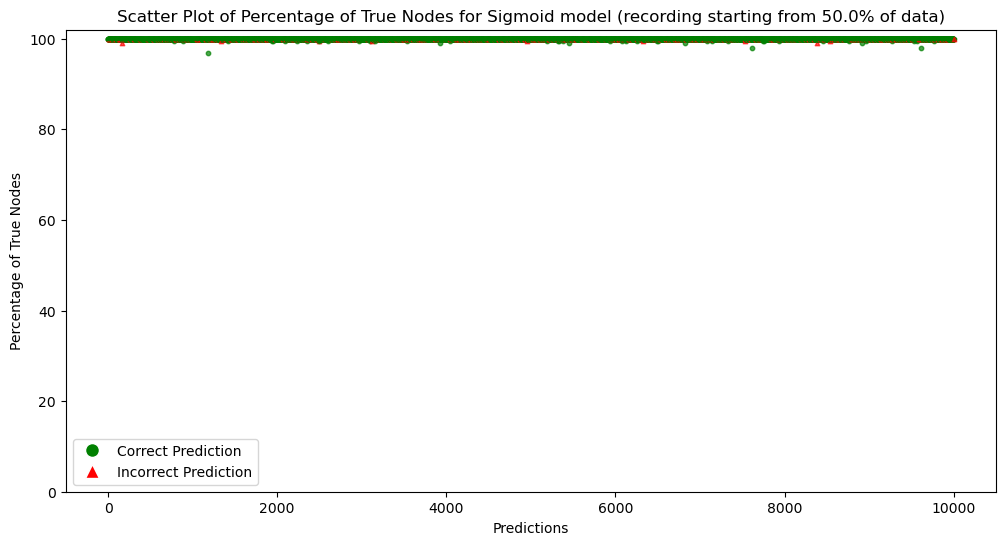

Model Accuracy = 93.39%


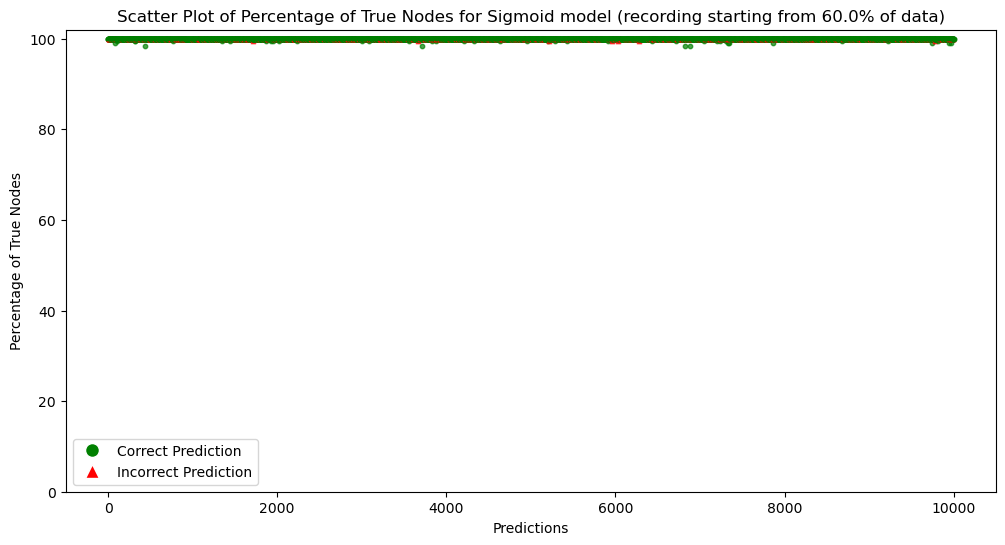

Percent 0.1 has correlation 0.006348183953767763 and pvalue 0.525594456640409
Percent 0.2 has correlation 0.001995109215352999 and pvalue 0.8418824530626364
Percent 0.3 has correlation 0.007089720831147732 and pvalue 0.47839127363970657
Percent 0.4 has correlation 0.034082652837217564 and pvalue 0.0006524223815534416
Percent 0.5 has correlation 0.02192681188335887 and pvalue 0.028331114856625293
Percent 0.6 has correlation 0.01043085330438503 and pvalue 0.29695602351654965


In [23]:
correlation_list = []
for percentage, model_sigmoid in models_dict.items():
    accuracy_sigmoid, percent_list_sigmoid, prediction_list_sigmoid = evaluate_model(model_sigmoid, valloader, trim = False, n_std = 2)
    print(f"Model Accuracy = {accuracy_sigmoid * 100}%")
    plot_percentage_scatter(percent_list_sigmoid, prediction_list_sigmoid, num_points=None, ymin=0, ymax=102,
                           title = f"Scatter Plot of Percentage of True Nodes for Sigmoid model (recording starting from {percentage*100}% of data)")
    r_pb, p_value = pointbiserialr(prediction_list_sigmoid, percent_list_sigmoid)
    correlation_list.append((r_pb, p_value))

for i,percent in enumerate(models_dict.keys()):
    print(f"Percent {percent} has correlation {correlation_list[i][0]} and pvalue {correlation_list[i][1]}")